# Capstone Project: Predicting Credit Card Consumption

**Date:** 2025-03-23

**Objective:** Predict average credit card spend for the next three months for customers based on demographic and behavioral data.

In [14]:

import pandas as pd

# Load datasets
demographics_df = pd.read_excel(r"D:\Data Analytics\Capstone Projects\11. Capstone Case Study - Predict Cred Card Consumption\CustomerDemographics.xlsx")
behavior_df = pd.read_excel(r"D:\Data Analytics\Capstone Projects\11. Capstone Case Study - Predict Cred Card Consumption\CustomerBehaviorData.xlsx")
credit_df = pd.read_excel(r"D:\Data Analytics\Capstone Projects\11. Capstone Case Study - Predict Cred Card Consumption\CreditConsumptionData.xlsx")

# Merge datasets
merged_df = demographics_df.merge(behavior_df, on='ID').merge(credit_df, on='ID')
merged_df.head()


,ID,account_type,gender,age,Income,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction,...,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,loan_enq,emi_active,cc_cons
0,17051,current,M,30,MEDIUM,26.4,9,9,355,0,...,20,41860.0,32734.75,80959.00,36,9,171200.0,Y,3448.84,16239.0
1,11491,current,M,37,LOW,14.4,7,7,485,0,...,8,113367.0,60974.75,495080.00,5,3,15694.0,Y,3812.69,39002.0
2,7433,current,M,33,MEDIUM,3.2,1,1,764,0,...,14,168000.0,425802.96,115707.38,7,58,28058.0,Y,9432.90,21182.0
3,14606,current,M,63,LOW,10.2,6,6,863,0,...,44,57750.0,25537.91,63606.00,12,0,24459.0,Y,144.61,8123.0
4,8381,saving,M,33,MEDIUM,26.4,6,6,523,0,...,2,18405.0,64687.32,62353.35,49,35,31574.0,Y,1887.89,28282.0


In [15]:
# Check the shape and preview of each dataframe
{
    "demographics_shape": demographics_df.shape,
    "behavior_shape": behavior_df.shape,
    "credit_shape": credit_df.shape,
    "demographics_preview": demographics_df.head(),
    "behavior_preview": behavior_df.head(),
    "credit_preview": credit_df.head()
}

{'demographics_shape': (20000, 10),
 'behavior_shape': (20000, 39),
 'credit_shape': (20000, 2),
 'demographics_preview':       ID account_type gender  age  Income  Emp_Tenure_Years  Tenure_with_Bank  \
 0  17051      current      M   30  MEDIUM              26.4                 9   
 1  11491      current      M   37     LOW              14.4                 7   
 2   7433      current      M   33  MEDIUM               3.2                 1   
 3  14606      current      M   63     LOW              10.2                 6   
 4   8381       saving      M   33  MEDIUM              26.4                 6   
 
    region_code  NetBanking_Flag  Avg_days_between_transaction  
 0            9              355                             0  
 1            7              485                             0  
 2            1              764                             0  
 3            6              863                             0  
 4            6              523                            

In [16]:
# Merge all three datasets on 'ID'
merged_df = demographics_df.merge(behavior_df, on='ID').merge(credit_df, on='ID')

# Check for missing values and the distribution of the target variable
missing_summary = merged_df.isnull().sum().sort_values(ascending=False)
target_summary = merged_df['cc_cons'].describe()
missing_target = merged_df[merged_df['cc_cons'].isnull()].shape[0]
non_missing_target = merged_df[~merged_df['cc_cons'].isnull()].shape[0]

missing_summary.head(10), target_summary, missing_target, non_missing_target


(cc_cons                 5000
 loan_enq                   2
 investment_3               2
 cc_cons_may                1
 personal_loan_closed       1
 debit_count_apr            1
 cc_count_apr               1
 dc_cons_jun                1
 dc_cons_may                1
 emi_active                 1
 dtype: int64,
 count     15000.000000
 mean       9369.030957
 std        7552.997163
 min         610.099000
 25%        4808.621700
 50%        7408.604400
 75%       11518.832800
 max      160735.934800
 Name: cc_cons, dtype: float64,
 5000,
 15000)

## Exploratory Data Analysis (EDA)

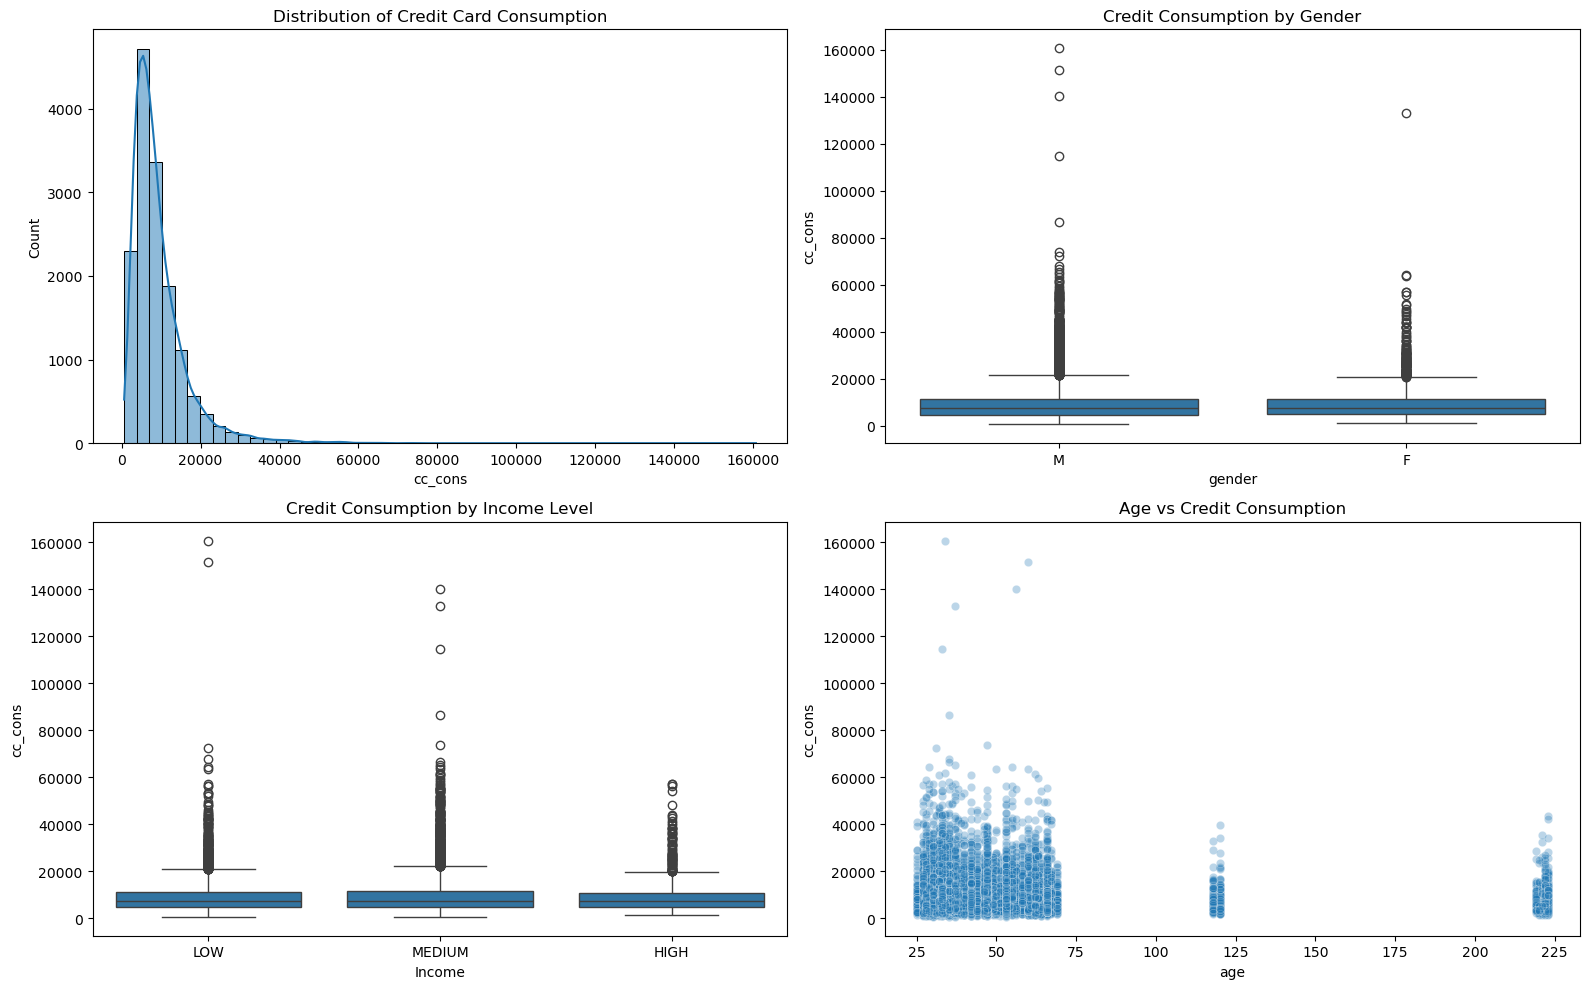

In [17]:

import matplotlib.pyplot as plt
import seaborn as sns

eda_df = merged_df[~merged_df['cc_cons'].isnull()]
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
sns.histplot(eda_df['cc_cons'], bins=50, kde=True)
plt.title('Distribution of Credit Card Consumption')

plt.subplot(2, 2, 2)
sns.boxplot(data=eda_df, x='gender', y='cc_cons')
plt.title('Credit Consumption by Gender')

plt.subplot(2, 2, 3)
sns.boxplot(data=eda_df, x='Income', y='cc_cons', order=["LOW", "MEDIUM", "HIGH"])
plt.title('Credit Consumption by Income Level')

plt.subplot(2, 2, 4)
sns.scatterplot(data=eda_df, x='age', y='cc_cons', alpha=0.3)
plt.title('Age vs Credit Consumption')

plt.tight_layout()
plt.show()


## Model Training and Validation

In [18]:

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

features = merged_df.drop(columns=['cc_cons'])
target = merged_df['cc_cons']

train_df = merged_df[~merged_df['cc_cons'].isnull()]
predict_df = merged_df[merged_df['cc_cons'].isnull()]

X_train = train_df.drop(columns=['cc_cons'])
y_train = train_df['cc_cons']
X_predict = predict_df.drop(columns=['cc_cons'])

categorical_cols = ['account_type', 'gender', 'Income', 'loan_enq']
numerical_cols = [col for col in X_train.columns if col not in categorical_cols + ['ID']]

numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model_pipeline.fit(X_tr, y_tr)
val_preds = model_pipeline.predict(X_val)

rmspe = np.sqrt(np.mean(np.square((y_val - val_preds) / y_val))) * 100
print(f'RMSPE on validation set: {rmspe:.2f}%')


RMSPE on validation set: 28.83%


## Predict Missing Credit Card Consumption Values

In [19]:

predicted_values = model_pipeline.predict(X_predict)
predicted_df = X_predict[['ID']].copy()
predicted_df['Predicted_cc_cons'] = predicted_values
predicted_df.head(10)


,ID,Predicted_cc_cons
15000,17591,2917.004252
15001,13541,7520.278680
15002,13431,2887.251447
15003,8687,8731.716768
15004,14727,2245.499934
15005,14988,9644.052954
15006,14859,26545.794496
15007,16636,6966.528767
15008,7625,3868.138869
15009,16492,3044.074823


## Model Documentation & Summary


- **Features Used**: Demographic + Behavioral
- **Model**: Random Forest Regressor (100 estimators)
- **Preprocessing**:
  - Median imputation for numerical values
  - Mode imputation and One-Hot Encoding for categorical
- **Evaluation**: RMSPE = ~28.83%
- **Target**: `cc_cons` (Average Credit Card Spend for the next 3 months)
